In [1]:
import sys

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scp.propylene_glycol import PropyleneGlycol
from scipy.optimize import minimize

In [2]:
%matplotlib inline
plt.style.use('fast')
plt.rcParams['figure.figsize'] = [10, 7]
plt.rcParams['font.size'] = 10

In [3]:
here = Path().resolve()
charge_path = here / "IceOnCoil" / "charge_1min_resample.csv"
disch_4_path = here / "IceOnCoil" / "discharge_4_1min_resample.csv"
disch_6_path = here / "IceOnCoil" / "discharge_6_1min_resample.csv"
disch_8_path = here / "IceOnCoil" / "discharge_8_1min_resample.csv"

In [4]:
pg = PropyleneGlycol(0.3)

In [5]:
def load_init_data(file_name):
    
    # load data
    df = pd.read_csv(file_name, index_col=["Time [min]"])
    
    # convert gal/min to m3/s
    # http://www.kylesconverter.com/flow/cubic-meters-per-second-to-gallons-(us-fluid)-per-minute
    m3sec_to_galmin = 15850.323144
    
    vdot_cols = {"V_ice [gal/min]": "V_ice [m3/s]",
                 "V_load [gal/min]": "V_load [m3/s]",
                 "V_cond [gal/min]": "V_cond [m3/s]"
                }
    
    for k, v in vdot_cols.items():
        df[k] = df[k] / m3sec_to_galmin
    
    # rename vdot cols
    df.rename(columns=vdot_cols, inplace=True)
    
    # compute brine mass flow rate
    df["mdot_ice [kg/s]"] = np.nan
    for idx in range(len(df["V_ice [m3/s]"])):
        inlet_temp = df["T_ice_in [C]"].iloc[idx]
        density = pg.density(inlet_temp)
        df["mdot_ice [kg/s]"].iloc[idx] = density * df["V_ice [m3/s]"].iloc[idx]
    
    # compute cooling rate
    df["Q_ice [kW]"] = np.nan
    for idx in range(len(df["V_ice [m3/s]"])):
        inlet_temp = df["T_ice_in [C]"].iloc[idx]
        outlet_temp = df["T_ice_out [C]"].iloc[idx]
        cp = pg.specific_heat(inlet_temp) / 1000.0
        mdot = df["mdot_ice [kg/s]"].iloc[idx]
        df["Q_ice [kW]"].iloc[idx] = mdot * cp * (inlet_temp - outlet_temp)

    # compute cumulative HT
    q_exp = np.array(df["Q_ice [kW]"])
    cumsum_q = np.cumsum(q_exp)
    df["Q_ice_sum [kWh]"] = cumsum_q * (1/60)
        
    # chiller power W to kW
    df["Pwr_chiller [W]"] /= 1000.0
    df.rename({"Pwr_chiller [W]": "Pwr_chiller [kW]"}, inplace=True, axis=1)
        
    # return early if we can't compute COP
    if df["T_evap_in [C]"].isnull().all():
        return df
    
    # compute chiller cop
    df["COP"] = np.nan
    df["Q_evap [kW]"] = np.nan
    for idx in range(len(df["V_ice [m3/s]"])):
        evap_inlet_temp = df["T_evap_in [C]"].iloc[idx]
        evap_outlet_temp = df["T_evap_out [C]"].iloc[idx]
        ave_temp = (evap_inlet_temp + evap_outlet_temp) / 2.0
        cp = pg.specific_heat(ave_temp) / 1000.0
        mdot = df["mdot_ice [kg/s]"].iloc[idx]
        q_evap = mdot * cp * (evap_outlet_temp - evap_inlet_temp)
        df["Q_evap [kW]"].iloc[idx] = q_evap
        pwr = df["Pwr_chiller [kW]"].iloc[idx]
        df["COP"].iloc[idx] = abs(q_evap / pwr)
        
    return df

In [6]:
df_charge = load_init_data(charge_path)

In [7]:
def plot_tin_tout(df):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
    col = "T_ice_in [C]"
    ax1.plot(df[col], label=col)
    
    col = "T_ice_out [C]"
    ax1.plot(df[col], label=col)
    ax1.grid()
    ax1.legend()
    
    col = "mdot_ice [kg/s]"
    ax2.plot(df[col], label=col)
    ax2.grid()
    ax2.legend()
    
    col = "Q_ice [kW]"
    ax3.plot(df[col], label=col)
    ax3.grid()
    ax3.legend()
    
    col = "Q_ice_sum [kWh]"
    ax4.plot(df[col], label=col)
    ax4.grid()
    ax4.legend()
    
    plt.show()

## Charging

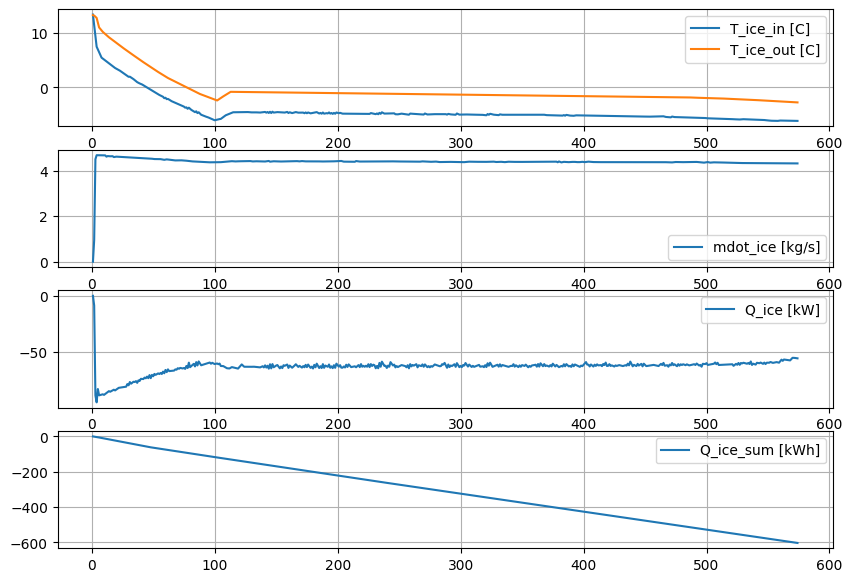

In [8]:
plot_tin_tout(df_charge)

## Discharging

In [9]:
df_4 = load_init_data(disch_4_path)

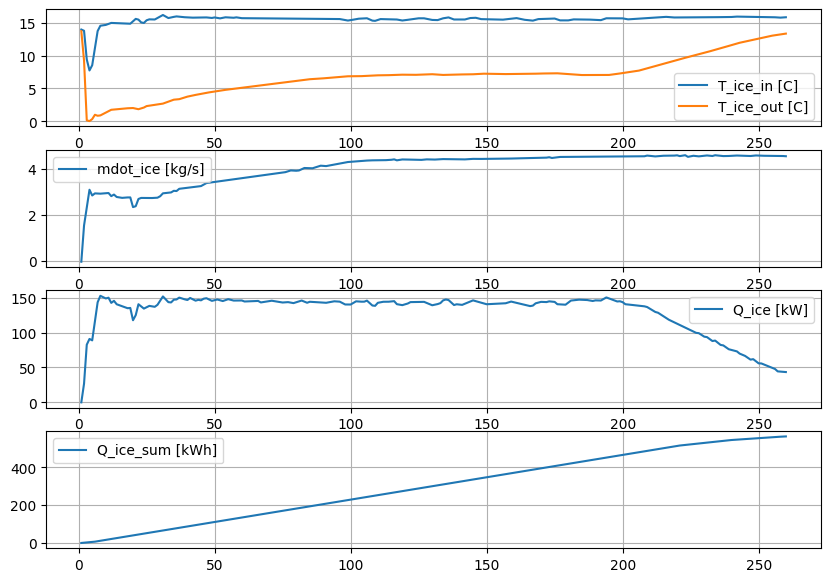

In [10]:
plot_tin_tout(df_4)

In [11]:
df_6 = load_init_data(disch_6_path)

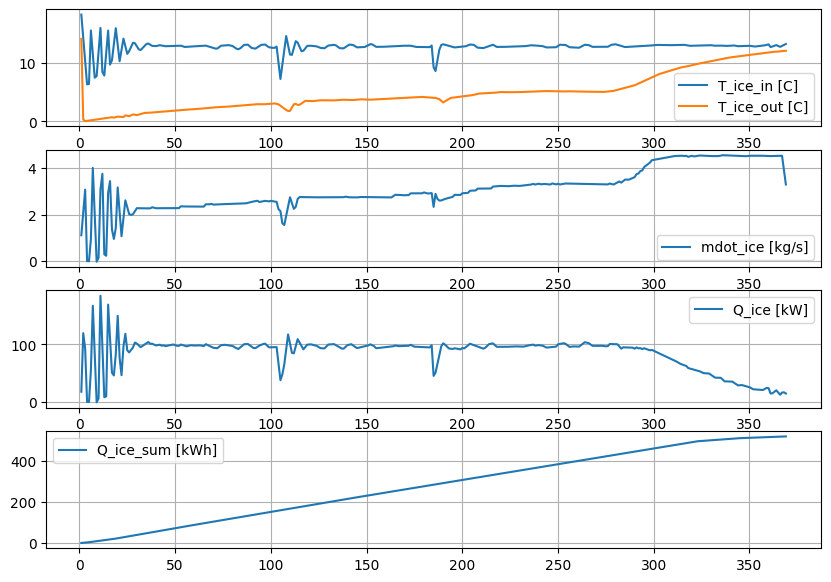

In [12]:
plot_tin_tout(df_6)

In [13]:
df_8 = load_init_data(disch_8_path)

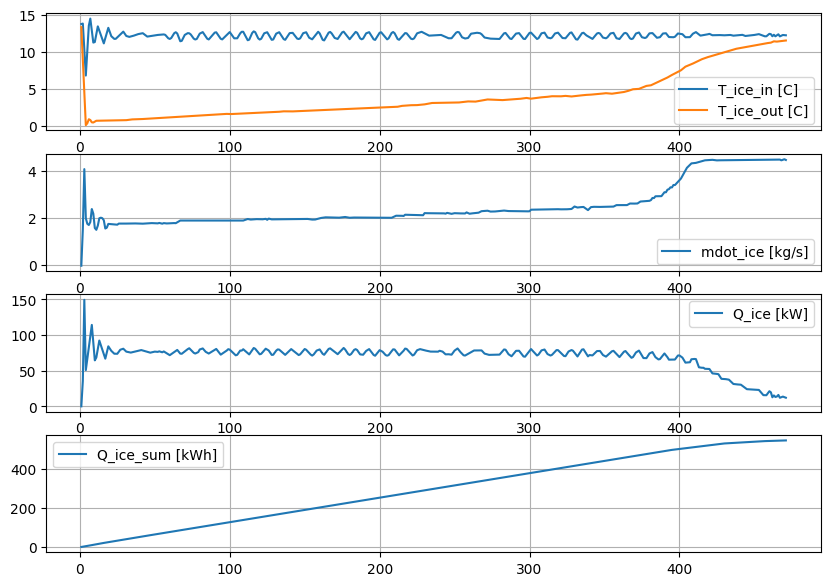

In [14]:
plot_tin_tout(df_8)

In [15]:
thermal_tank_path = here.parent
sys.path.insert(0, str(thermal_tank_path))

from thermaltank.simple_ice_tank import IceTank

In [16]:
def f_ua(x, c0, c1, c2, c3):
    return np.dot(np.array([c0, c1, c2, c3]), np.array([1, x, x**2, x**3]))

In [17]:
def monotonic(vals):
    # https://stackoverflow.com/a/4983359
    return all(x<=y for x, y in zip(vals, vals[1:])) or all(x>=y for x, y in zip(vals, vals[1:]))

In [18]:
x0_charge = [52000.0, -125000.0, 225000.0, -145000.0]
x0_discharge = [1.848e+03, 7.429e+04, -1.419e+05, 9.3659e+04]

In [19]:
def f_ssqe(coeffs, data_frames, c_charge=None, c_discharge=None):
    
    c0, c1, c2, c3 = coeffs
  
    ua_test_vals = [f_ua(x, c0, c1, c2, c3) for x in np.arange(0, 1.1, 0.1)]

    # test if values are less than 0
    if any([x < 2000 for x in ua_test_vals]):
        return 1e16
    
    # check if function is monotonic
    if not monotonic(ua_test_vals):
        print("not monotonic")
        return 1e16
    
    ssqe = 0
       
    iter_data = {
        "tank_diameter": 89 * 0.0254,  # 89 inches
        "tank_height": 101 * 0.0254,  # 101 inches
        "fluid_volume": 1655 * 0.00378541,  # 1655 gal
        "r_value_lid": 24 / 5.67826,  # R-24
        "r_value_base": 9 / 5.67826,  # R-9
        "r_value_wall": 9 / 5.67826,  # R-9
    }

    if c_charge:
        iter_data["coeff_c3_ua_charging"] = c_charge[3]
        iter_data["coeff_c2_ua_charging"] = c_charge[2]
        iter_data["coeff_c1_ua_charging"] = c_charge[1]
        iter_data["coeff_c0_ua_charging"] = c_charge[0]
        iter_data["coeff_c3_ua_discharging"] = c3
        iter_data["coeff_c2_ua_discharging"] = c2
        iter_data["coeff_c1_ua_discharging"] = c1
        iter_data["coeff_c0_ua_discharging"] = c0
        iter_data["latent_state_of_charge"] = 1.0

    if c_discharge:
        iter_data["coeff_c3_ua_charging"] = c3
        iter_data["coeff_c2_ua_charging"] = c2
        iter_data["coeff_c1_ua_charging"] = c1
        iter_data["coeff_c0_ua_charging"] = c0
        iter_data["coeff_c3_ua_discharging"] = c_discharge[3]
        iter_data["coeff_c2_ua_discharging"] = c_discharge[2]
        iter_data["coeff_c1_ua_discharging"] = c_discharge[1]
        iter_data["coeff_c0_ua_discharging"] = c_discharge[0]
        iter_data["initial_temperature"] = 13
        
    for idx, df in enumerate(data_frames):
        
        inlet_temps = df["T_ice_in [C]"].values
        mass_flow_rates = df["mdot_ice [kg/s]"].values
        
        tank = IceTank(iter_data)
        
        outlet_temps = []
        ice_mass = []
        q_model = []

        time = 0
        timestep = 60
    
        for idx, t in enumerate(inlet_temps):
            m_dot = mass_flow_rates[idx]
            t_env = 20
            tank.calculate(t, m_dot, t_env, time, timestep)
            t_out = tank.outlet_fluid_temp
            outlet_temps.append(t_out)
            ice_mass.append(tank.ice_mass)
            
            t_mft_model = (t + t_out) / 2.0
            cp_model = pg.specific_heat(t_mft_model)
            q_model_kw = m_dot * cp_model * (t - t_out) / 1000
            q_model_kwh = q_model_kw / 60
            q_model.append(q_model_kwh)
            time += timestep
            
        cumsum_q_exp = np.array(df["Q_ice_sum [kWh]"])

        q_model = np.array(q_model)       
        cumsum_q_model = np.cumsum(q_model)
        ssqe_tank = np.sum((cumsum_q_model - cumsum_q_exp) ** 2)
        ssqe += ssqe_tank
        
    print(f"SSQE: {ssqe}")
    return ssqe

In [20]:
def f_ssqe_discharge(coeffs):
    return f_ssqe(coeffs, [df_4, df_6, df_8], c_charge=x0_charge)

In [21]:
def f_ssqe_charge(coeffs):
    return f_ssqe(coeffs, [df_charge], c_discharge=x0_discharge)

In [22]:
ret_dis = minimize(f_ssqe_discharge, 
                   x0=np.array(x0_discharge))

In [23]:
ret_dis

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1e+16
        x: [ 1.848e+03  7.429e+04 -1.419e+05  9.366e+04]
      nit: 0
      jac: [ 0.000e+00  0.000e+00  0.000e+00  0.000e+00]
 hess_inv: [[1 0 0 0]
            [0 1 0 0]
            [0 0 1 0]
            [0 0 0 1]]
     nfev: 5
     njev: 1

In [24]:
ret_ch = minimize(f_ssqe_charge, 
                  x0=np.array(x0_charge))

SSQE: 551320.2960799792
SSQE: 551320.2960816488
SSQE: 551320.2960807588
SSQE: 551320.296080435
SSQE: 551320.2960802738
SSQE: 551189.9139412498
SSQE: 551189.9139429203
SSQE: 551189.9139420231
SSQE: 551189.9139417061
SSQE: 551189.9139415603
SSQE: 550668.4853735927
SSQE: 550668.4853752553
SSQE: 550668.4853743676
SSQE: 550668.4853740511
SSQE: 550668.4853738865
SSQE: 548584.3734756833
SSQE: 548584.3734773549
SSQE: 548584.3734764694
SSQE: 548584.3734761513
SSQE: 548584.3734760046
SSQE: 540273.7291586043
SSQE: 540273.7291602625
SSQE: 540273.7291593674
SSQE: 540273.7291590528
SSQE: 540273.7291589014
SSQE: 507454.6841792979
SSQE: 507454.6841809281
SSQE: 507454.6841800639
SSQE: 507454.6841797416
SSQE: 507454.68417959224
SSQE: 383664.6385452568
SSQE: 383664.6385467342
SSQE: 383664.63854592445
SSQE: 383664.6385456484
SSQE: 383664.6385455062
SSQE: 383664.63854334306
SSQE: 383664.6385448278
SSQE: 383664.638544019
SSQE: 383664.63854373683
SSQE: 383664.6385435951
SSQE: 383664.6385414093
SSQE: 383664.6

In [25]:
ret_ch

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 230247.01029778848
        x: [ 4.950e+04 -1.262e+05  2.243e+05 -1.454e+05]
      nit: 2
      jac: [ 8.079e+01  3.547e+01  1.986e+01  1.260e+01]
 hess_inv: [[ 5.202e+01  2.372e+01  1.384e+01  8.930e+00]
            [ 2.372e+01  1.203e+01  6.432e+00  4.152e+00]
            [ 1.384e+01  6.432e+00  4.752e+00  2.422e+00]
            [ 8.930e+00  4.152e+00  2.422e+00  2.563e+00]]
     nfev: 228
     njev: 44

In [26]:
def plot_exp(df, data, plot_name, title):
       
    inlet_temps = df["T_ice_in [C]"]
    mass_flow_rates = df["mdot_ice [kg/s]"].values

    tank = IceTank(data)

    outlet_temps = []
    ice_mass = []

    time = 0
    timestep = 60
    
    for idx, t in enumerate(inlet_temps):
        mdot = mass_flow_rates[idx]    
        t_env = 20
        tank.calculate(t, mdot, t_env, time, timestep)
        outlet_temps.append(tank.outlet_fluid_temp)
        ice_mass.append(tank.ice_mass)
        time += timestep
    
    # create figure with four subplots
    fig, (ax1, ax2, ax3, ax4)= plt.subplots(4,1)
    
    fig.suptitle(f"{title}", fontsize=20)
    
    # populate subplot 1
    ax1.plot(inlet_temps, label=r"$T_{in}$ Exp")
    ax1.plot(df["T_ice_out [C]"].values, label=r"$T_{out}$ Exp")
    ax1.plot(outlet_temps, label=r"$T_{out}$ Model", linestyle="--")
    ax1.set_ylabel("Temp [C]")
    ax1.legend(ncol=3)
    ax1.grid()
    
    # populate subplot 2
    ax4.plot(ice_mass, label="Model", linestyle="--")
    ax4.set_xlabel("Time [min]")
    ax4.set_ylabel("Ice Mass [kg]")
    ax4.legend()
    ax4.grid()
    
    # populate subplot 3
    q_exp = []
    q_model = []
    
    for idx, t in enumerate(inlet_temps):
        # exp q
        t_out_exp = df["T_ice_out [C]"].iloc[idx]
        t_mft_exp = (t + t_out_exp) / 2.0
        cp_exp = pg.specific_heat(t_mft_exp)
        m_dot = mass_flow_rates[idx]
        q_exp_watts = m_dot * cp_exp * (t - t_out_exp)
        q_exp_kwh = q_exp_watts * (1/1000) * (60/3600)
        q_exp.append(q_exp_kwh)
        
        # model q
        t_out_model = outlet_temps[idx]
        t_mft_model = (t + t_out_model) / 2.0
        cp_model = pg.specific_heat(t_mft_model)
        q_model_watts = m_dot * cp_model * (t - t_out_model)
        q_model_kwh = q_model_watts * (1/1000) * (60/3600)
        q_model.append(q_model_kwh)
    
    q_exp = np.array(q_exp)
    cumsum_q_exp = np.cumsum(q_exp)
    
    q_model = np.array(q_model)
    cumsum_q_model = np.cumsum(q_model)
    
    ax2.plot(cumsum_q_exp, label="Exp")
    ax2.plot(cumsum_q_model, label="Model", linestyle="--") 
    ax2.set_ylabel("Sum HT [kWh]")
    ax2.legend(ncol=2)
    ax2.grid()
    
    ssqe = np.sum((cumsum_q_model - cumsum_q_exp) ** 2)
    print(f"SSQE: {ssqe}")

    # populate subplot 4
    q_error = (cumsum_q_exp - cumsum_q_model) / cumsum_q_exp * 100.0
    ax3.plot(q_error)
    ax3.set_yticks(range(-20, 30, 10))
    ax3.set_ylim([-20, 20])
    ax3.set_ylabel("HT Error [%]")
    ax3.grid()
    
    plot_path = thermal_tank_path / 'validation' / f"{plot_name}.png"
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

SSQE: 219189.77695591704


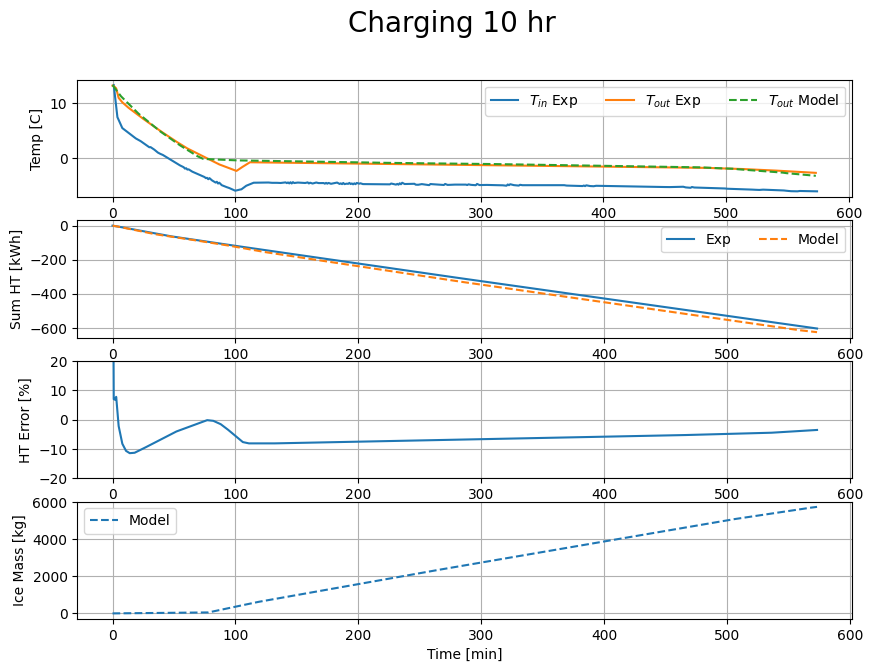

In [27]:
data_base = {
        "tank_diameter": 89 * 0.0254,  # 89 inches
        "tank_height": 101 * 0.0254,  # 101 inches
        "fluid_volume": 1655 * 0.00378541,  # 1655 gal
        "r_value_lid": 24 / 5.67826,  # R-24
        "r_value_base": 9 / 5.67826,  # R-9
        "r_value_wall": 9 / 5.67826,  # R-9
        "coeff_c3_ua_charging": ret_ch.x[3],
        "coeff_c2_ua_charging": ret_ch.x[2],
        "coeff_c1_ua_charging": ret_ch.x[1],
        "coeff_c0_ua_charging": ret_ch.x[0],
        "coeff_c3_ua_discharging": ret_dis.x[3],
        "coeff_c2_ua_discharging": ret_dis.x[2],
        "coeff_c1_ua_discharging": ret_dis.x[1],
        "coeff_c0_ua_discharging": ret_dis.x[0],
}

data_charge = {**data_base, **{"initial_temperature": 13.0}}

data_discharge = {**data_base, **{"latent_state_of_charge": 1.0}}

plot_exp(df_charge, data_charge, "charge", "Charging 10 hr")

SSQE: 60043.1018481283


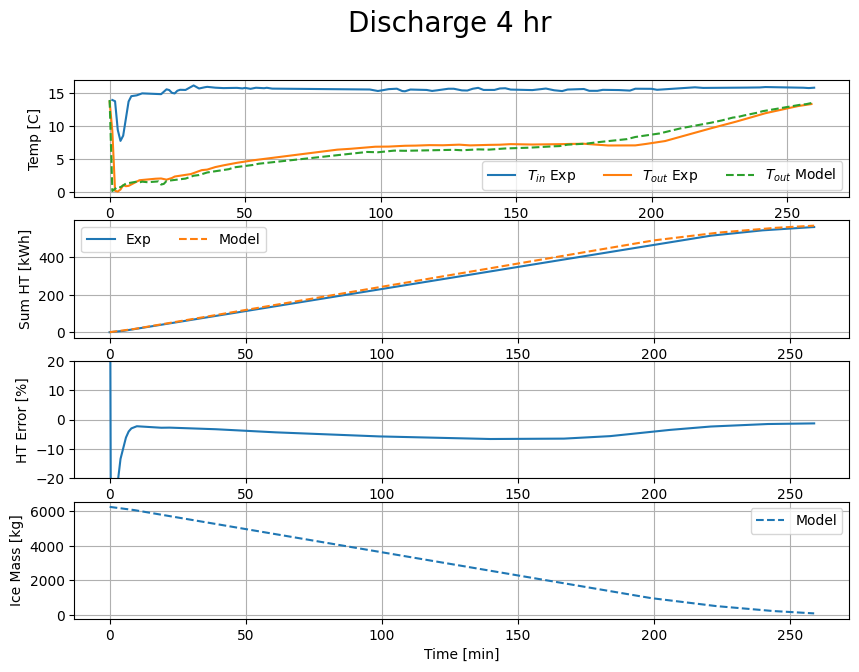

In [28]:
plot_exp(df_4, data_discharge, "discharge_4", "Discharge 4 hr")

SSQE: 225073.8459812252


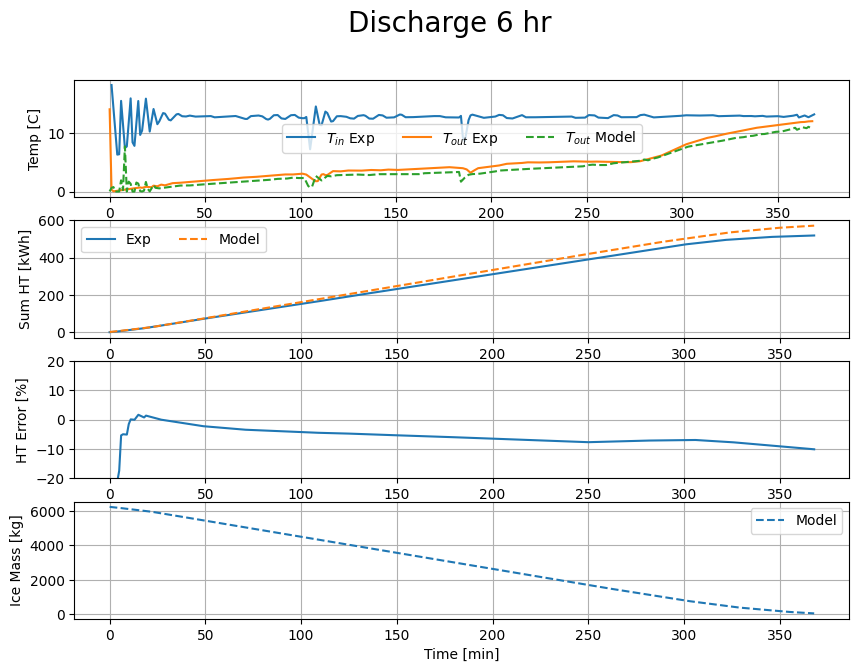

In [29]:
plot_exp(df_6, data_discharge, "discharge_6", "Discharge 6 hr")

SSQE: 245421.58718061683


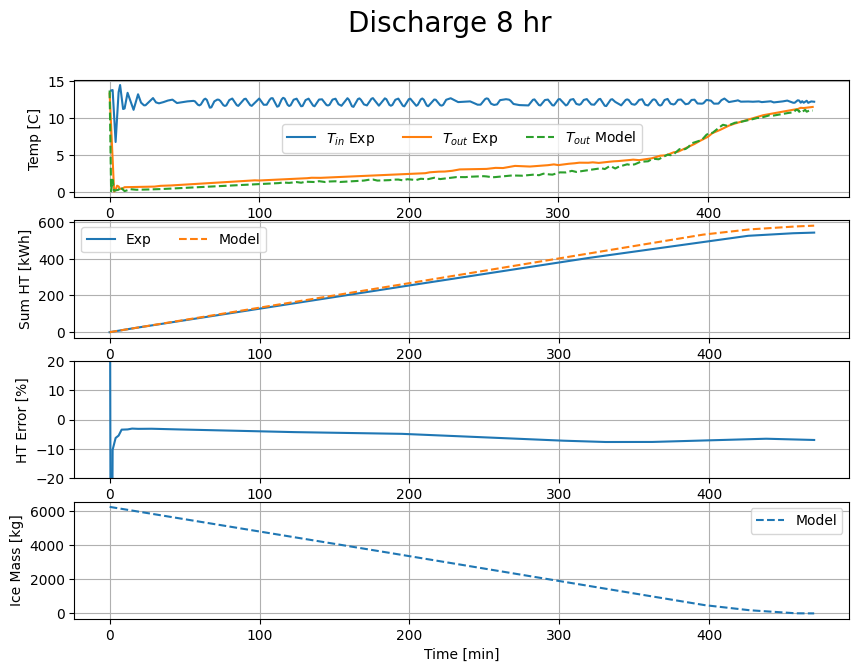

In [30]:
plot_exp(df_8, data_discharge, "discharge_8", "Discharge 8 hr")

In [31]:
def plot_charge_effectiveness():

    tank = IceTank(data_charge)
    tank.tank_is_charging = True
    
    soc_range = np.linspace(0, 1, 20).tolist()
    eff_1 = []
    m_dot = 2
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_1.append(tank.effectiveness(-2.0, m_dot))
    
    eff_2 = []
    m_dot = 4
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_2.append(tank.effectiveness(-2.0, m_dot))
    
    eff_3 = []
    m_dot = 6
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_3.append(tank.effectiveness(-2.0, m_dot))
    
    fig, ax = plt.subplots(1,1)
    ax.plot(soc_range, eff_1, label="mdot= 2 kg/s", marker="x")
    ax.plot(soc_range, eff_2, label="mdot= 4 kg/s", marker="x")
    ax.plot(soc_range, eff_3, label="mdot= 6 kg/s", marker="x")
    ax.set_xlabel("SOC")
    ax.set_ylabel("Effectiveness")
    ax.set_title("Charging")
    ax.grid()
    ax.legend()
    plot_path = thermal_tank_path / 'validation' / f"charge_eff.png"
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

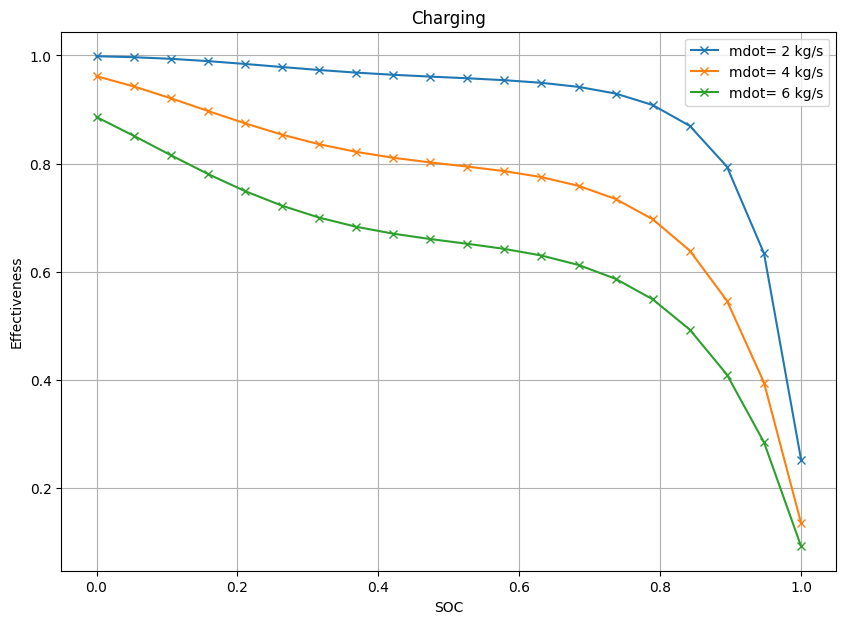

In [32]:
plot_charge_effectiveness()

In [33]:
def plot_discharge_effectiveness():

    tank = IceTank(data_discharge)
    tank.tank_is_charging = False
    
    soc_range = np.linspace(1, 0, 40).tolist()
    eff_1 = []
    m_dot = 2
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_1.append(tank.effectiveness(15.0, m_dot))
    
    eff_2 = []
    m_dot = 4
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_2.append(tank.effectiveness(15.0, m_dot))
    
    eff_3 = []
    m_dot = 6
    for soc in soc_range:
        tank.ice_mass = tank.total_fluid_mass * soc
        eff_3.append(tank.effectiveness(15.0, m_dot))
    
    fig, ax = plt.subplots(1,1)
    ax.plot(soc_range, eff_1, label="mdot= 2 kg/s", marker="x")
    ax.plot(soc_range, eff_2, label="mdot= 4 kg/s", marker="x")
    ax.plot(soc_range, eff_3, label="mdot= 6 kg/s", marker="x")
    ax.set_xlabel("SOC")
    ax.set_ylabel("Effectiveness")
    ax.set_title("Discharging")
    ax.grid()
    ax.legend()
    plot_path = thermal_tank_path / 'validation' / f"discharge_eff.png"
    plt.savefig(plot_path, bbox_inches="tight")
    plt.show()

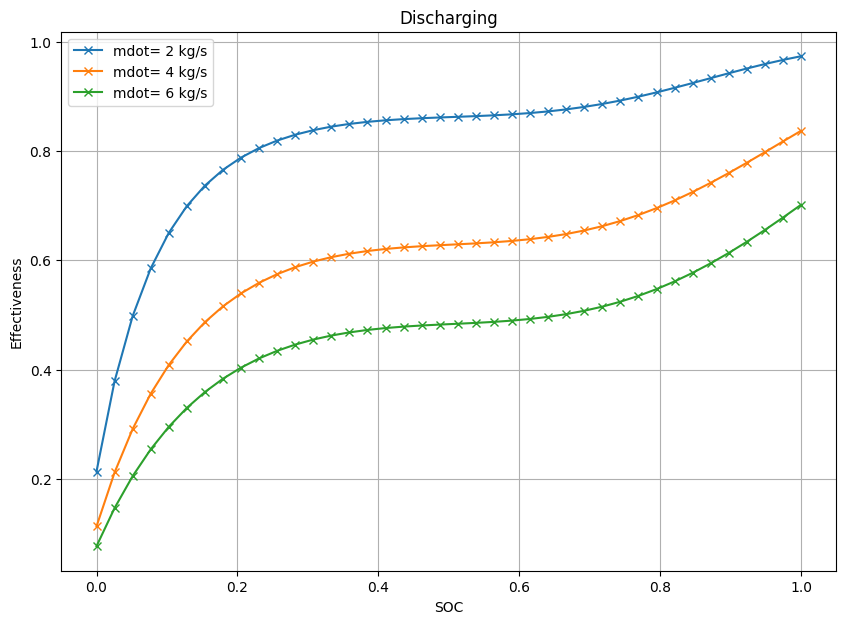

In [34]:
plot_discharge_effectiveness()

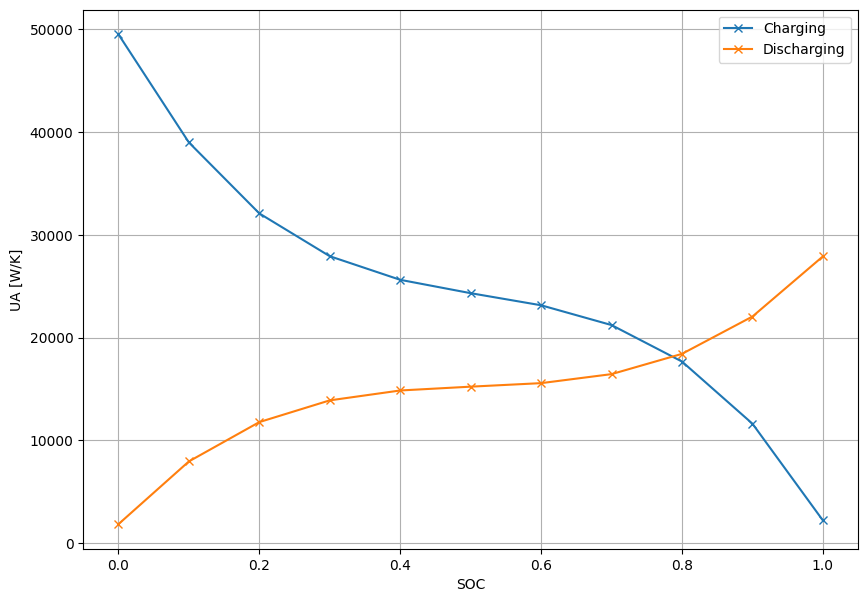

In [35]:
x_arr = np.arange(0, 1.1, 0.1)

ua_ch = [f_ua(x, *ret_ch.x) for x in x_arr]
ua_dis = [f_ua(x, *ret_dis.x) for x in x_arr]

fig, ax = plt.subplots()

ax.plot(x_arr, ua_ch, label="Charging", marker="x")
ax.plot(x_arr, ua_dis, label="Discharging", marker="x")

ax.set_ylabel("UA [W/K]")
ax.set_xlabel("SOC")

plt.legend()
plt.grid()
plt.show()

In [36]:
ua_ch

[49500.18776777793,
 38981.38725250813,
 32076.31377867995,
 27912.32604912059,
 25616.782766657307,
 24317.042634117308,
 23140.464354327847,
 21214.40663011615,
 17666.228164309447,
 11623.287659734953,
 2212.943819219916]

In [37]:
ua_dis

[1848.0,
 7951.659,
 11779.272,
 13892.793000000001,
 14854.175999999998,
 15225.375,
 15568.344000000005,
 16445.037,
 18417.407999999996,
 22047.410999999993,
 27897.0]